In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
import seaborn as sns


In [2]:
dir_path1 = "data/entklerg-redo2/"
# Load Pickled Data
file_path1 = dir_path1 + "data_eval_dict.pickle"
with open(file_path1, 'rb') as f: 
    data_dict1 = pickle.load(f, encoding="bytes")
    print(data_dict1.keys())
obj1 = data_dict1['obj_loc']
obj2 = data_dict1['obj2_loc']
traj1 = data_dict1['path']
loss1 = data_dict1['losses']
buffer1 = data_dict1['buffer']
action1 = data_dict1['actions']
env_traj1 = data_dict1['env_path']
env_lim = data_dict1['tray_lim']
klerg_lim = data_dict1['klerg_lim']
print(obj1)

dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])
(-0.15, -0.1, -0.35)


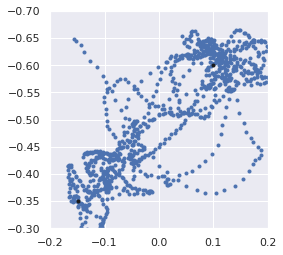

In [3]:
sns.set(style='darkgrid')
# Plot Traj
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')
plt.plot(obj1[0], obj1[2],'k.')
plt.plot(0.1, -0.6,'k.')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
plt.show()


[ 0.04278586  0.3        -0.65382026] [0.21392931568084927, 0.7691013116178249] (-0.15, -0.1, -0.35)
tensor([[-0.7500, -0.7500]])
torch.Size([1, 6]) torch.Size([1, 2])
torch.Size([1, 6]) torch.Size([1, 2])


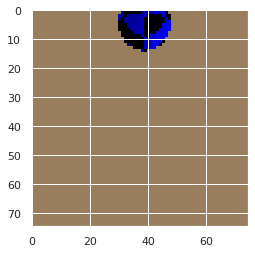

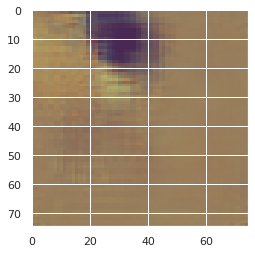

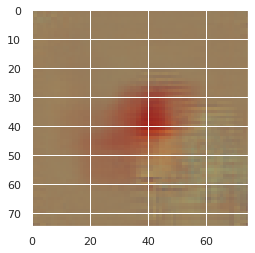

In [4]:
from franka.franka_utils import *

# Load Pytorch Models
model1 = torch.load(dir_path1 + "model_final.pth")
model1.eval()

print(env_traj1[-1,:], buffer1[-1][0], obj1)

xr = np.expand_dims(buffer1[-1][0], axis=0)
yr = np.expand_dims(buffer1[-1][1], axis=0)

xr = torch.FloatTensor(xr)#.squeeze()
yr = torch.FloatTensor(yr)#.squeeze()
x_obj = ws_conversion([obj1[0],obj1[2]], env_lim, klerg_lim)

x_obj = torch.FloatTensor(np.expand_dims(x_obj,axis=0))
print(x_obj)
with torch.no_grad():
    img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(xr, yr)
    z_samples = model1.reparameterize(z_mu, z_logvar)

    print(z_samples.shape, xr.shape)
    y_pred = model1.img_decode(torch.cat([z_samples, xr], dim=1))
    img_pred = model1.img_decoder(y_pred)

    print(z_samples.shape, x_obj.shape)
    yo_pred = model1.img_decode(torch.cat([z_samples, x_obj], dim=1))
    imgo_pred = model1.img_decoder(yo_pred)

img_new = img_pred.detach().numpy()[0].T
img_new = np.clip(img_new,0,1)

imgo_new = imgo_pred.detach().numpy()[0].T
imgo_new = np.clip(imgo_new,0,1)

img_orig = yr.detach().numpy()[0].T

plt.imshow(img_orig)
plt.show()

plt.imshow(img_new)
plt.show()

plt.imshow(imgo_new)
plt.show()


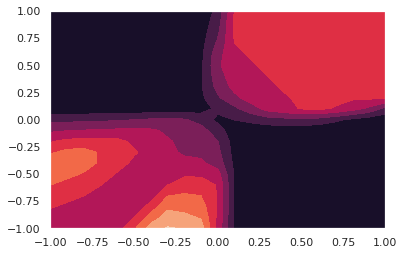

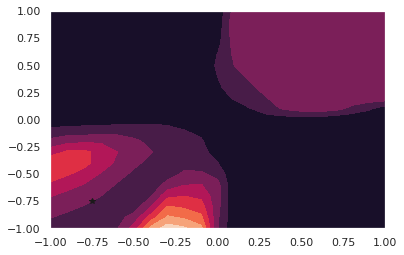

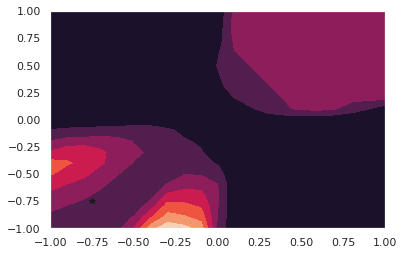

In [5]:
obj_ss = ws_conversion([obj1[0],obj1[2]], env_lim, klerg_lim)

xlist = np.linspace(klerg_lim[0,0],klerg_lim[0,1],21)
ylist = np.linspace(klerg_lim[1,0],klerg_lim[1,1],21)

xx, yy = np.meshgrid(xlist, ylist)
pts = np.array([xx.ravel(), yy.ravel()]).T
var_list = []
ent_list = []
with torch.no_grad():
    for i in range(len(pts)):
        x = torch.FloatTensor(np.expand_dims(pts[i],
                                             axis=0))
        img_logvar = model1.imgvar_decoder(torch.cat([z_samples, x],
                                                 dim=1))
        # img_logvar = torch.clamp(img_logvar, -5, 2)
        var = img_logvar[0].exp().detach().numpy()
        var_list.append(var)

        ent_list.append(var**2)
var_list = np.array(var_list)

plt.contourf(xx,yy,var_list.reshape(xx.shape))
# plt.plot(obj_ss[0], obj_ss[1],'k*')
plt.show()

ent_list = np.array(ent_list)

plt.contourf(xx,yy,ent_list.reshape(xx.shape))
plt.plot(obj_ss[0], obj_ss[1],'k*')
plt.show()

var_data = (var_list/np.max(var_list))**2 #4
var_data = np.array(var_data).squeeze()
plt.contourf(xx,yy,var_data.reshape(xx.shape))
plt.plot(obj_ss[0], obj_ss[1],'k*')
plt.show()


torch.Size([1, 6]) torch.Size([1, 2])
torch.Size([1, 6]) torch.Size([1, 2])


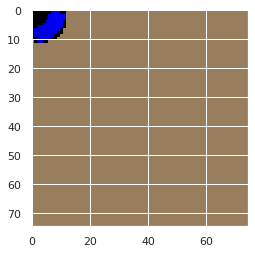

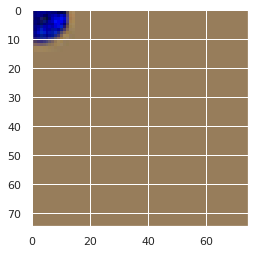

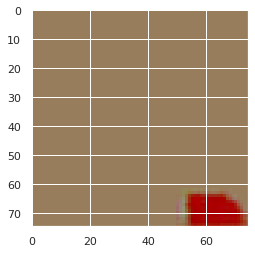

In [6]:
buffer1 = np.array(buffer1)
sample = buffer1[np.random.choice(buffer1.shape[0], 1, replace=False)]

x, y = map(np.stack, zip(*sample))

x = torch.FloatTensor(x)#.squeeze()
y = torch.FloatTensor(y)#.squeeze()

x_obj = torch.FloatTensor(np.expand_dims([obj1[0],obj1[2]],axis=0))

with torch.no_grad():
    img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(x, y)
    z_samples = model1.reparameterize(z_mu, z_logvar)

    print(z_samples.shape, x.shape)
    y_pred = model1.img_decode(torch.cat([z_samples, x], dim=1))
    img_pred = model1.img_decoder(y_pred)

    print(z_samples.shape, x_obj.shape)
    yo_pred = model1.img_decode(torch.cat([z_samples, x_obj], dim=1))
    imgo_pred = model1.img_decoder(yo_pred)

img_new = img_pred.detach().numpy()[0].T
img_new = np.clip(img_new,0,1)

imgo_new = imgo_pred.detach().numpy()[0].T
imgo_new = np.clip(imgo_new,0,1)

img_orig = y.detach().numpy()[0].T

plt.imshow(img_orig)
plt.show()

plt.imshow(img_new)
plt.show()

plt.imshow(imgo_new)
plt.show()


In [7]:
mseloss = nn.MSELoss()

loss1 = []
for i in range(20,500,10):
    PATH =  dir_path1 + "model_checkpoint_iter"+str(i)+".pth"
    model1.load_state_dict(torch.load(PATH)['state_dict'])
    model1.eval()

    with torch.no_grad():
        img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(x, y)
        z_samples = model1.reparameterize(z_mu, z_logvar)

        y_pred = model1.img_decode(torch.cat([z_samples, x], dim=1))
        img_pred = model1.img_decoder(y_pred)
        loss1.append(mseloss(img_pred, yr))

model1 = torch.load(dir_path1 + "model_final.pth")
model1.eval()

img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(x, y)
z_samples = model1.reparameterize(z_mu, z_logvar)

y_pred = model1.img_decode(torch.cat([z_samples, x], dim=1))
img_pred = model1.img_decoder(y_pred)
loss1.append(mseloss(img_pred, y))

plt.plot(loss1)
plt.show()

RuntimeError: Error(s) in loading state_dict for VAE:
	size mismatch for encode.0.weight: copying a param with shape torch.Size([128, 5122]) from checkpoint, the shape in current model is torch.Size([64, 5122]).
	size mismatch for encode.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encode.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for encode.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encode.4.weight: copying a param with shape torch.Size([12, 128]) from checkpoint, the shape in current model is torch.Size([12, 64]).
	size mismatch for imgvar_decoder.0.weight: copying a param with shape torch.Size([128, 8]) from checkpoint, the shape in current model is torch.Size([64, 8]).
	size mismatch for imgvar_decoder.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for imgvar_decoder.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for imgvar_decoder.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for imgvar_decoder.4.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 64]).
	size mismatch for img_decode.0.weight: copying a param with shape torch.Size([128, 8]) from checkpoint, the shape in current model is torch.Size([64, 8]).
	size mismatch for img_decode.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for img_decode.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for img_decode.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for img_decode.4.weight: copying a param with shape torch.Size([5120, 128]) from checkpoint, the shape in current model is torch.Size([5120, 64]).

In [5]:
dir_path2 = "data/unifklerg-redo/"
# Load Pickled Data
file_path2 = dir_path2 + "data_eval_dict.pickle"
with open(file_path2, 'rb') as f: 
    data_dict2 = pickle.load(f, encoding="bytes")
    print(data_dict2.keys())
obj2 = data_dict2['obj_loc']
traj2 = data_dict2['path']
loss2 = data_dict2['losses']
buffer2 = data_dict2['buffer']
action2 = data_dict2['actions']
env_traj2 = data_dict2['env_path']
env_lim = data_dict2['tray_lim']
klerg_lim = data_dict2['klerg_lim']

# Load Pytorch Models
model2 = torch.load(dir_path2 + "model_final.pth")
model2.eval()


dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])


/home/anon/.local/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'vae.vae.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
    (3): Flatten()
  )
  (encode): Sequential(
    (0): Linear(in_features=5122, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (img_decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(5, 3, kernel_size=(5, 5), stride=(2, 2))
  )
  (imgvar_decoder): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (img_decode): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

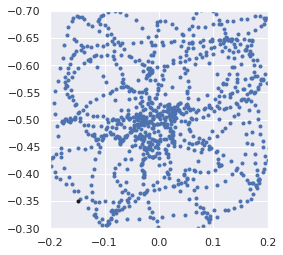

In [9]:
sns.set(style='darkgrid')
# Plot Traj
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj2 = np.array(env_traj2)
plt.plot(env_traj2[:,0], env_traj2[:,2],'b.')
plt.plot(obj2[0], obj2[2],'k.')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
plt.show()

tensor([[-0.7500, -0.7500]])
torch.Size([1, 6]) torch.Size([1, 2])
torch.Size([1, 6]) torch.Size([1, 2])


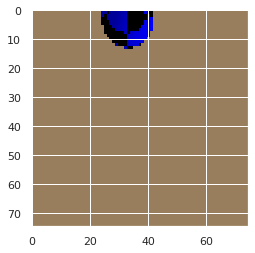

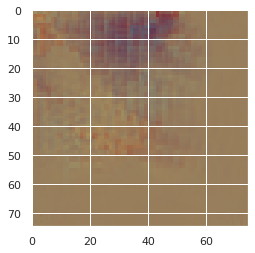

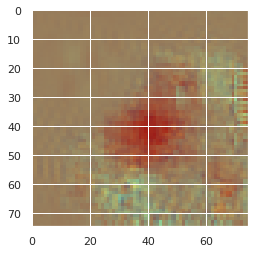

In [10]:
from franka.franka_utils import *

# Load Pytorch Models

xr = np.expand_dims(buffer2[-1][0], axis=0)
yr = np.expand_dims(buffer2[-1][1], axis=0)

xr = torch.FloatTensor(xr)#.squeeze()
yr = torch.FloatTensor(yr)#.squeeze()
x_obj = ws_conversion([obj2[0],obj2[2]], env_lim, klerg_lim)

x_obj = torch.FloatTensor(np.expand_dims(x_obj,axis=0))
print(x_obj)
with torch.no_grad():
    img_pred, img_logvar , z_mu, z_logvar, z_samples = model2(xr, yr)
    z_samples = model2.reparameterize(z_mu, z_logvar)

    print(z_samples.shape, xr.shape)
    y_pred = model2.img_decode(torch.cat([z_samples, xr], dim=1))
    img_pred = model2.img_decoder(y_pred)

    print(z_samples.shape, x_obj.shape)
    yo_pred = model2.img_decode(torch.cat([z_samples, x_obj], dim=1))
    imgo_pred = model2.img_decoder(yo_pred)

img_new = img_pred.detach().numpy()[0].T
img_new = np.clip(img_new,0,1)

imgo_new = imgo_pred.detach().numpy()[0].T
imgo_new = np.clip(imgo_new,0,1)

img_orig = yr.detach().numpy()[0].T

plt.imshow(img_orig)
plt.show()

plt.imshow(img_new)
plt.show()

plt.imshow(imgo_new)
plt.show()


torch.Size([1, 6]) torch.Size([1, 2])
torch.Size([1, 6]) torch.Size([1, 2])


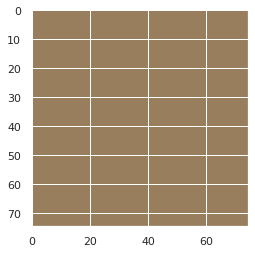

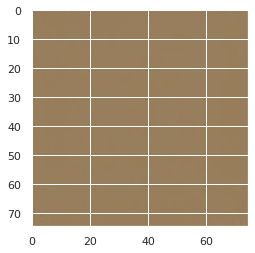

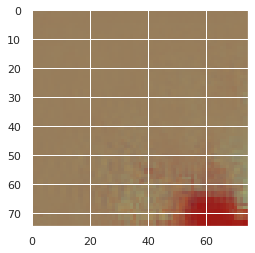

In [11]:
buffer2 = np.array(buffer2)
sample = buffer2[np.random.choice(buffer2.shape[0], 1, replace=False)]

x, y = map(np.stack, zip(*sample))

x = torch.FloatTensor(x)#.squeeze()
y = torch.FloatTensor(y)#.squeeze()

x_obj = torch.FloatTensor(np.expand_dims([obj1[0],obj1[2]],axis=0))

with torch.no_grad():
    img_pred, img_logvar , z_mu, z_logvar, z_samples = model2(x, y)
    z_samples = model2.reparameterize(z_mu, z_logvar)

    print(z_samples.shape, x.shape)
    y_pred = model2.img_decode(torch.cat([z_samples, x], dim=1))
    img_pred = model2.img_decoder(y_pred)

    print(z_samples.shape, x_obj.shape)
    yo_pred = model2.img_decode(torch.cat([z_samples, x_obj], dim=1))
    imgo_pred = model2.img_decoder(yo_pred)

img_new = img_pred.detach().numpy()[0].T
img_new = np.clip(img_new,0,1)

imgo_new = imgo_pred.detach().numpy()[0].T
imgo_new = np.clip(imgo_new,0,1)

img_orig = y.detach().numpy()[0].T

plt.imshow(img_orig)
plt.show()

plt.imshow(img_new)
plt.show()

plt.imshow(imgo_new)
plt.show()

In [12]:
mseloss = nn.MSELoss()
num_samples = 10
loss1 = np.empty((num_samples,49))
loss2 = np.empty((num_samples,49))
samples = []
for ind in range(num_samples):
    buffer1 = np.array(buffer1)
    sample = buffer1[np.random.choice(buffer1.shape[0], 1, replace=False)]
    samples.append(sample)

    x, y = map(np.stack, zip(*sample))

    x = torch.FloatTensor(x)#.squeeze()
    y = torch.FloatTensor(y)#.squeeze()
    j = 0
    for i in range(20,500,10):
        PATH =  dir_path2 + "model_checkpoint_iter"+str(i)+".pth"
        model2.load_state_dict(torch.load(PATH)['state_dict'])
        model2.eval()

        with torch.no_grad():
            img_pred, img_logvar , z_mu, z_logvar, z_samples = model2(x, y)
            z_samples = model2.reparameterize(z_mu, z_logvar)

            y_pred = model2.img_decode(torch.cat([z_samples, x], dim=1))
            img_pred = model2.img_decoder(y_pred)
            loss2[ind, j] = mseloss(img_pred, y)
        j+=1

    model2 = torch.load(dir_path2 + "model_final.pth")
    model2.eval()

    img_pred, img_logvar , z_mu, z_logvar, z_samples = model2(x, y)
    z_samples = model2.reparameterize(z_mu, z_logvar)

    y_pred = model2.img_decode(torch.cat([z_samples, x], dim=1))
    img_pred = model2.img_decoder(y_pred)
    loss2[ind,j] = mseloss(img_pred, y)
    # plt.imshow(y[0].T)
    # plt.show()
    # plt.imshow(img_pred[0].detach().numpy().T)
    # plt.show()

    j = 0
    for i in range(20,500,10):
        PATH =  dir_path1 + "model_checkpoint_iter"+str(i)+".pth"
        model1.load_state_dict(torch.load(PATH)['state_dict'])
        model1.eval()

        with torch.no_grad():
            img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(x, y)
            z_samples = model1.reparameterize(z_mu, z_logvar)

            y_pred = model1.img_decode(torch.cat([z_samples, x], dim=1))
            img_pred = model1.img_decoder(y_pred)
            loss1[ind,j] = mseloss(img_pred, y)
        j += 1

    model1 = torch.load(dir_path1 + "model_final.pth")
    model1.eval()

    img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(x, y)
    z_samples = model1.reparameterize(z_mu, z_logvar)

    y_pred = model1.img_decode(torch.cat([z_samples, x], dim=1))
    img_pred = model1.img_decoder(y_pred)
    loss1[ind,j] = mseloss(img_pred, y)

    # plt.imshow(img_pred[0].detach().numpy().T)
# plt.show()

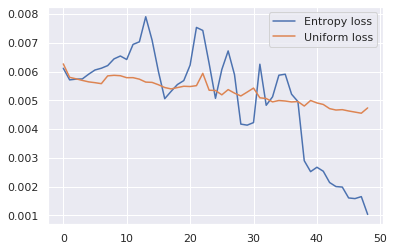

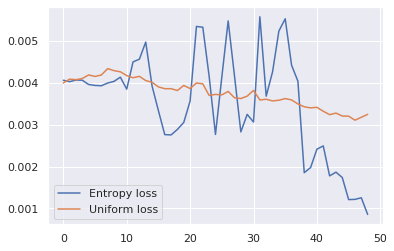

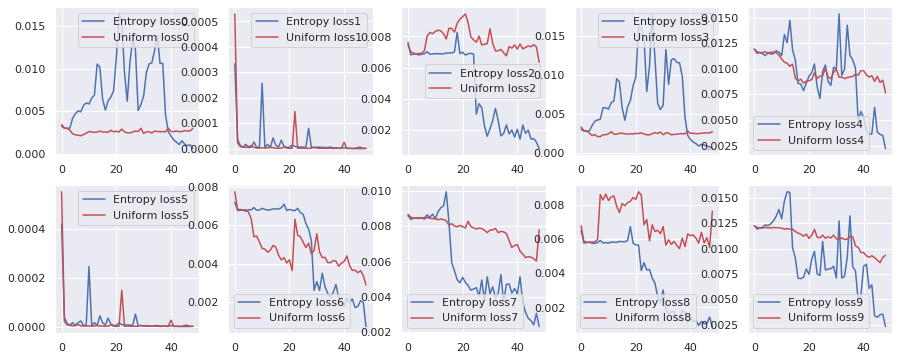

In [13]:
plt.plot(np.mean(loss1, 0), label='Entropy loss')
plt.plot(np.mean(loss2,0), label='Uniform loss')
plt.legend()
plt.show()

plt.plot(np.std(loss1, 0), label='Entropy loss')
plt.plot(np.std(loss2,0), label='Uniform loss')
plt.legend()
plt.show()

fig, axes = plt.subplots(2,5, figsize=(15, 6))

for i in range(num_samples):
    label1 = 'Entropy loss' + str(i)
    label2 = 'Uniform loss' + str(i)
    axes[i//5, i % 5].plot(loss1[i,:],'b', label=label1)
    axes[i//5, i % 5].plot(loss2[i,:],'r', label=label2)
    axes[i//5, i % 5].legend()
plt.show()


In [8]:
model1 = torch.load(dir_path1 + "model_final_postlearning.pth")
model1.eval()

# Load test data

dir_path = "data/test_data/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)


ycheck1 = [None]*len(testbuffer)
ycheck2 = [None]*len(testbuffer)

with torch.no_grad():
    xt = np.expand_dims(testbuffer[0][0], axis=0)
    yt = np.expand_dims(testbuffer[0][1], axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    ind = 0
    for i in range(int(len(testbuffer)/2)):
        print(ind)
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        ycheck1[ind] = img_pred1
        
        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        ycheck2[ind] = img_pred2
        
        ind +=1
        
    print(ind)
    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(testbuffer[ind][1], axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        ycheck1[ind] = img_pred1
        
        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        ycheck2[ind] = img_pred2
        print(ind)
        ind += 1
print(ind)


dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.15, -0.1, -0.35) (0.15, -0.1, -0.65)
0
1
2
3
4
5
6
7
8
9
9
10
11
12
13
14
15
16
17
18


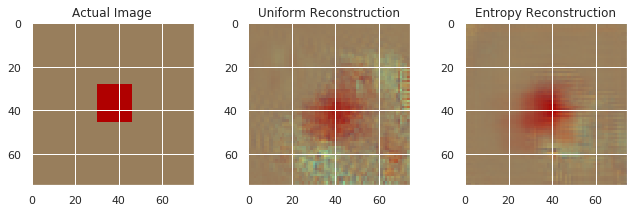

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


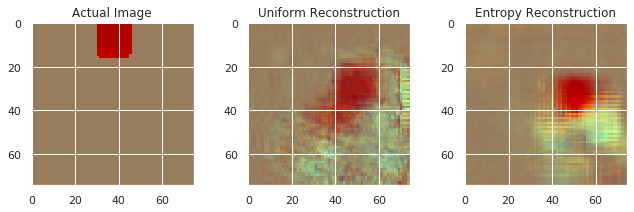

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


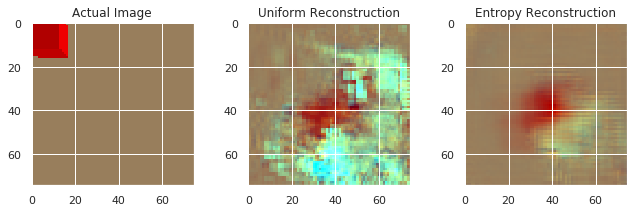

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


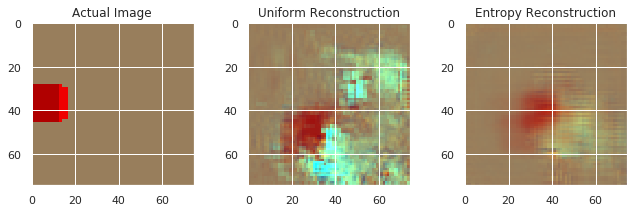

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


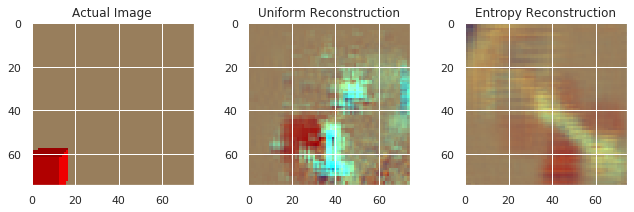

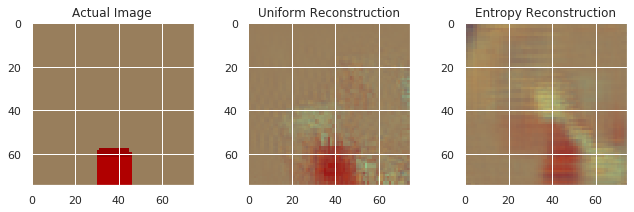

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


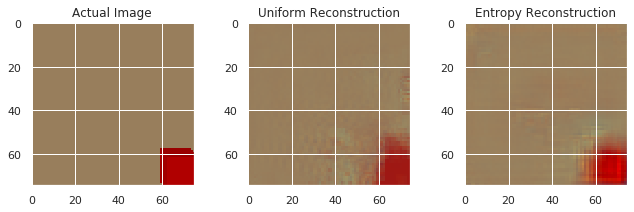

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


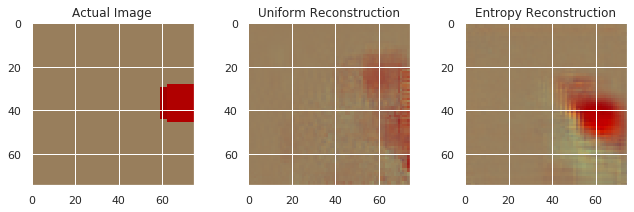

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


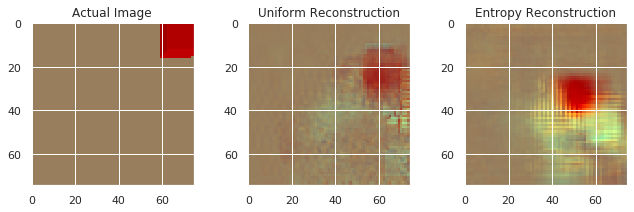

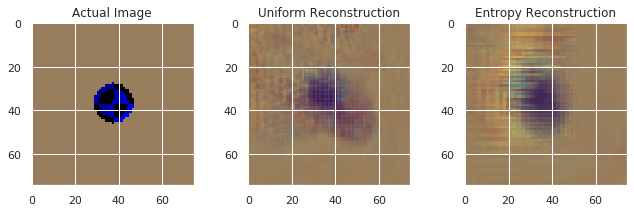

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


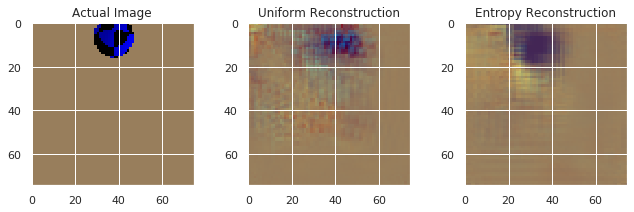

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


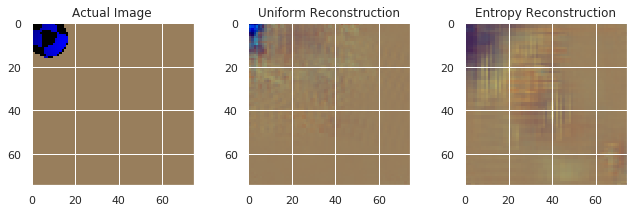

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


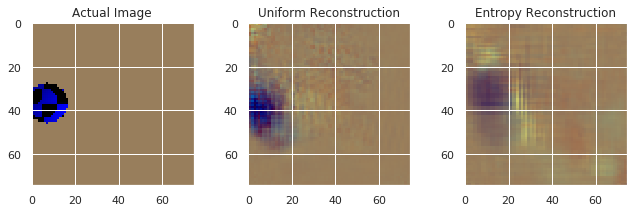

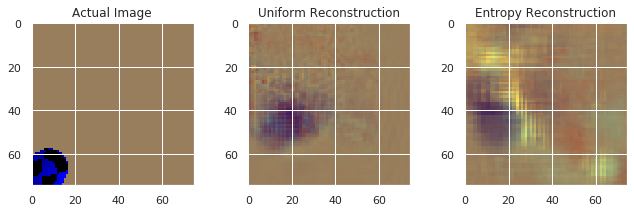

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


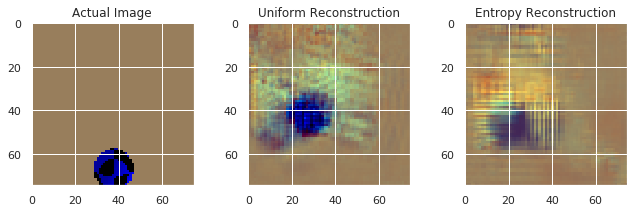

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


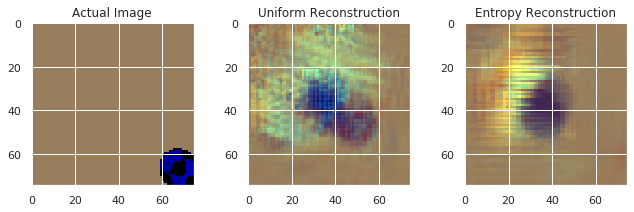

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


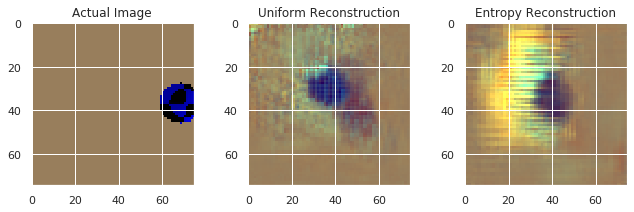

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


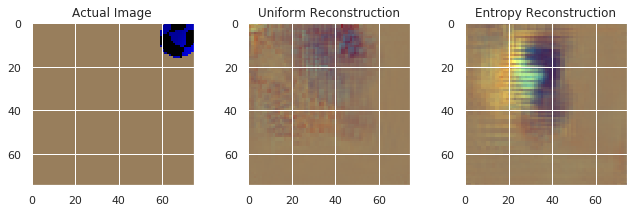

In [9]:
for i in range(len(testbuffer)):
    fig, axes = plt.subplots(1,3, figsize=(11, 3))
    axes[0].imshow(testbuffer[i][1].T)
    axes[0].set_title('Actual Image')
    axes[1].imshow((ycheck2[i][0]).T)
    axes[1].set_title("Uniform Reconstruction")
    axes[2].imshow((ycheck1[i][0]).T)
    axes[2].set_title("Entropy Reconstruction")

    fig.savefig(str(i)+'_imgcomp.png')
    plt.show()

    

In [29]:
print(len(testbuffer))

19


In [16]:
mseloss = nn.MSELoss()
num_samples = len(testbuffer)
loss1 = np.empty((num_samples, 49))
loss2 = np.empty((num_samples, 49))
samples = []


with torch.no_grad():
    j = 0
    for i in range(20,500,10):
        PATH =  dir_path1 + "model_checkpoint_iter"+str(i)+".pth"
        model1.load_state_dict(torch.load(PATH)['state_dict'])
        model1.eval()

        PATH =  dir_path2 + "model_checkpoint_iter"+str(i)+".pth"
        model2.load_state_dict(torch.load(PATH)['state_dict'])
        model2.eval()
        
        ind = 0
        xt = np.expand_dims(testbuffer[ind][0], axis=0)
        yt = np.expand_dims(testbuffer[ind][1], axis=0)
        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)
        for i in range(int(len(testbuffer)/2)):
            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()
            yc = np.expand_dims(testbuffer[ind][1], axis=0)
            yc = torch.FloatTensor(yc)#.squeeze()

            y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = model1.img_decoder(y_pred)
            loss1[ind, j] = mseloss(img_pred1[0], yc[0])

            y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = model2.img_decoder(y_pred)
            loss2[ind, j] = mseloss(img_pred2[0], yc[0])
            ind += 1

        xt = np.expand_dims(testbuffer[ind][0], axis=0)
        yt = np.expand_dims(testbuffer[ind][1], axis=0)
        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        for i in range(int(len(testbuffer)/2)):
            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()
            yc = np.expand_dims(testbuffer[ind][1], axis=0)
            yc = torch.FloatTensor(yc)#.squeeze()

            y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = model1.img_decoder(y_pred)
            loss1[ind, j] = mseloss(img_pred1[0], yc[0])

            y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = model2.img_decoder(y_pred)
            loss2[ind, j] = mseloss(img_pred2[0], yc[0])
            ind += 1
            
        j += 1
            
    print(j)        
    model1 = torch.load(dir_path1 + "model_final.pth")
    model1.eval()
    
    model2 = torch.load(dir_path2 + "model_final.pth")
    model2.eval()
    

    ind = 0
    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(testbuffer[ind][1], axis=0)
    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)
    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()
        yc = np.expand_dims(testbuffer[ind][1], axis=0)
        yc = torch.FloatTensor(yc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        loss1[ind, j] = mseloss(img_pred1[0], yc[0])

        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        loss2[ind, j] = mseloss(img_pred2[0], yc[0])
        ind += 1

    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(testbuffer[ind][1], axis=0)
    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()
        yc = np.expand_dims(testbuffer[ind][1], axis=0)
        yc = torch.FloatTensor(yc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        loss1[ind, j] = mseloss(img_pred1[0], yc[0])

        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        loss2[ind, j] = mseloss(img_pred2[0], yc[0])
        ind += 1


48


(18, 49)


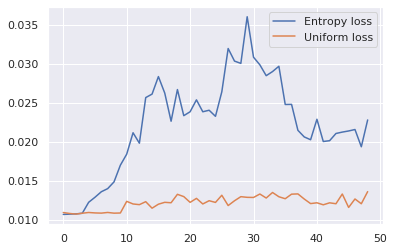

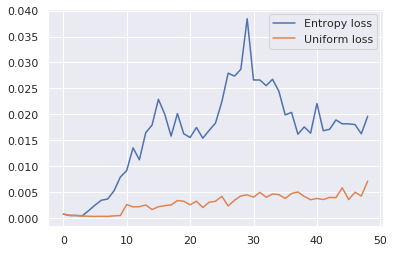

In [17]:
print(loss1.shape)
plt.plot(np.mean(loss1[9:], 0), label='Entropy loss')
plt.plot(np.mean(loss2[9:],0), label='Uniform loss')
plt.legend()
plt.show()

plt.plot(np.std(loss1[9:], 0), label='Entropy loss')
plt.plot(np.std(loss2[9:], 0), label='Uniform loss')
plt.legend()
plt.show()


In [18]:
imgcomp_list = [0,5,6,7,9,10,11,12]
mseloss = nn.MSELoss()
num_samples = len(imgcomp_list)
loss1 = np.empty((num_samples, 49))
loss2 = np.empty((num_samples, 49))
samples = []

with torch.no_grad():
    j = 0
    for i in range(20,500,10):
        PATH =  dir_path1 + "model_checkpoint_iter"+str(i)+".pth"
        model1.load_state_dict(torch.load(PATH)['state_dict'])
        model1.eval()

        PATH =  dir_path2 + "model_checkpoint_iter"+str(i)+".pth"
        model2.load_state_dict(torch.load(PATH)['state_dict'])
        model2.eval()
        
        ind = 0
        xt = np.expand_dims(testbuffer[ind][0], axis=0)
        yt = np.expand_dims(testbuffer[ind][1], axis=0)
        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)
        for i in range(int(len(imgcomp_list)/2)):
            xc = np.expand_dims(testbuffer[imgcomp_list[ind]][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()
            yc = np.expand_dims(testbuffer[imgcomp_list[ind]][1], axis=0)
            yc = torch.FloatTensor(yc)#.squeeze()

            y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = model1.img_decoder(y_pred)
            loss1[ind, j] = mseloss(img_pred1[0], yc[0])

            y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = model2.img_decoder(y_pred)
            loss2[ind, j] = mseloss(img_pred2[0], yc[0])
            ind += 1

        xt = np.expand_dims(testbuffer[9][0], axis=0)
        yt = np.expand_dims(testbuffer[9][1], axis=0)
        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        for i in range(int(len(imgcomp_list)/2)):
            xc = np.expand_dims(testbuffer[imgcomp_list[ind]][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()
            yc = np.expand_dims(testbuffer[imgcomp_list[ind]][1], axis=0)
            yc = torch.FloatTensor(yc)#.squeeze()

            y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = model1.img_decoder(y_pred)
            loss1[ind, j] = mseloss(img_pred1[0], yc[0])

            y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = model2.img_decoder(y_pred)
            loss2[ind, j] = mseloss(img_pred2[0], yc[0])
            ind += 1
            
        j += 1
            
    print(j)        
    model1 = torch.load(dir_path1 + "model_final.pth")
    model1.eval()
    
    model2 = torch.load(dir_path2 + "model_final.pth")
    model2.eval()
    

    ind = 0
    xt = np.expand_dims(testbuffer[imgcomp_list[ind]][0], axis=0)
    yt = np.expand_dims(testbuffer[imgcomp_list[ind]][1], axis=0)
    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)
    for i in range(int(len(imgcomp_list)/2)):
        xc = np.expand_dims(testbuffer[imgcomp_list[ind]][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()
        yc = np.expand_dims(testbuffer[imgcomp_list[ind]][1], axis=0)
        yc = torch.FloatTensor(yc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        loss1[ind, j] = mseloss(img_pred1[0], yc[0])

        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        loss2[ind, j] = mseloss(img_pred2[0], yc[0])
        ind += 1

    xt = np.expand_dims(testbuffer[9][0], axis=0)
    yt = np.expand_dims(testbuffer[9][1], axis=0)
    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)
    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    for i in range(int(len(imgcomp_list)/2)):
        xc = np.expand_dims(testbuffer[imgcomp_list[ind]][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()
        yc = np.expand_dims(testbuffer[imgcomp_list[ind]][1], axis=0)
        yc = torch.FloatTensor(yc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = model1.img_decoder(y_pred)
        loss1[ind, j] = mseloss(img_pred1[0], yc[0])

        y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = model2.img_decoder(y_pred)
        loss2[ind, j] = mseloss(img_pred2[0], yc[0])
        ind += 1


48


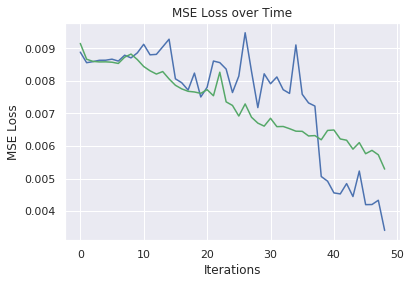

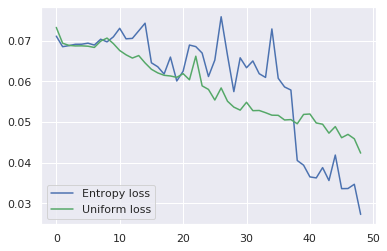

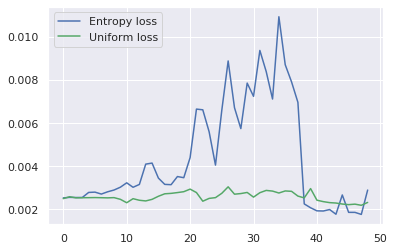

In [19]:
plt.plot(np.mean(loss1, 0),'b', label='Entropy loss')
plt.plot(np.mean(loss2,0),'g', label='Uniform loss')
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('MSE Loss over Time')
# plt.legend(loc="upper right")
# plt.savefig('Loss_vs_iterations.pdf')
plt.show()

plt.plot(np.sum(loss1, 0),'b', label='Entropy loss')
plt.plot(np.sum(loss2,0),'g', label='Uniform loss')
plt.legend()
plt.show()

plt.plot(np.std(loss1, 0),'b', label='Entropy loss')
plt.plot(np.std(loss2, 0),'g', label='Uniform loss')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


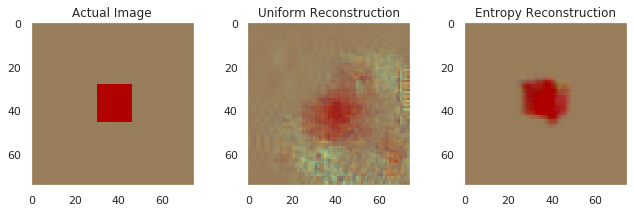

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


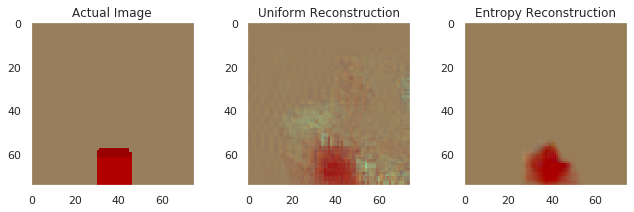

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


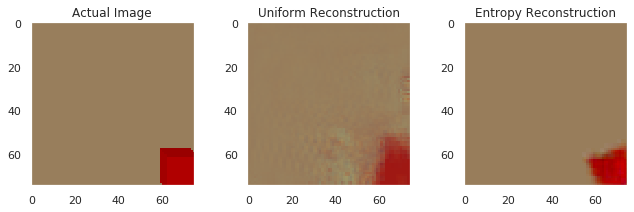

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


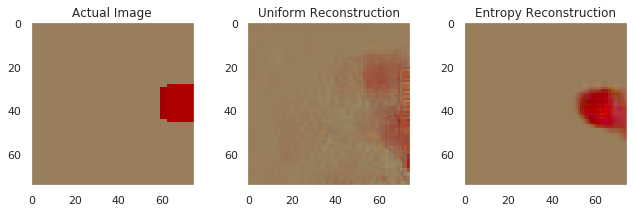

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


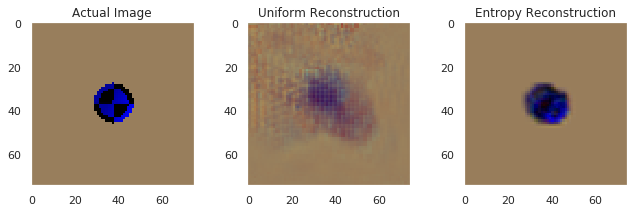

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


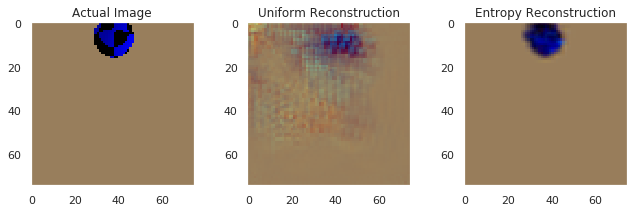

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


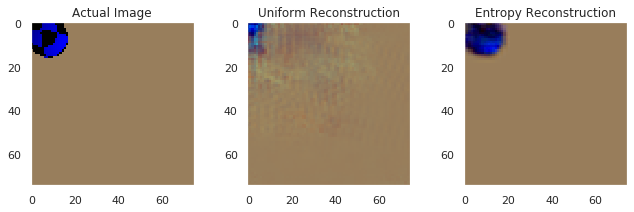

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


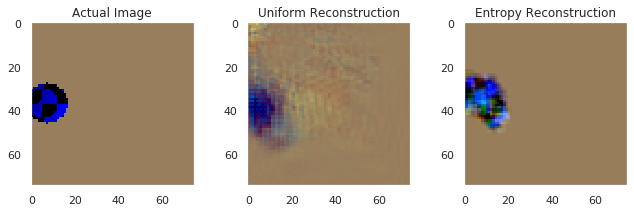

In [20]:
sns.set_style('dark')
for i in range(len(imgcomp_list)):
    fig, axes = plt.subplots(1,3, figsize=(11, 3))
    axes[0].imshow(testbuffer[imgcomp_list[i]][1].T)
    axes[0].set_title('Actual Image')
    axes[1].imshow((ycheck2[imgcomp_list[i]][0]).T)
    axes[1].set_title("Uniform Reconstruction")
    axes[2].imshow((ycheck1[imgcomp_list[i]][0]).T)
    axes[2].set_title("Entropy Reconstruction")

#     fig.savefig(str(i)+'_imgcomp.pdf')
    plt.show()

    

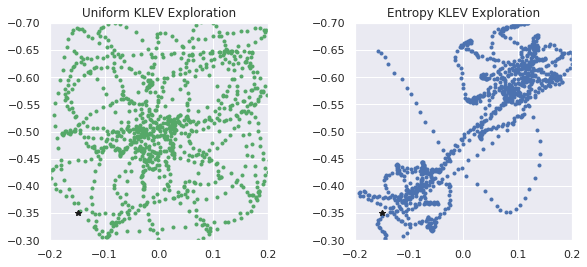

In [21]:
sns.set_style('darkgrid')
current_palette = sns.color_palette()
u_color=current_palette[1]
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].plot(env_traj2[:,0],env_traj2[:,2], 'g.')
axes[0].plot(obj1[0],obj1[2], 'k*')
axes[0].plot(obj2[0],obj2[2], 'k*')

axes[0].set_title("Uniform KLEV Exploration")
axes[0].axis('square')
axes[0].set_xlim(env_lim[0])
axes[0].set_ylim(env_lim[1])

axes[1].plot(env_traj1[:,0],env_traj1[:,2], 'b.')
axes[1].set_title("Entropy KLEV Exploration")
axes[1].axis('square')
axes[1].set_xlim(env_lim[0])
axes[1].set_ylim(env_lim[1])
axes[1].plot(obj1[0],obj1[2], 'k*')
axes[1].plot(obj2[0],obj2[2], 'k*')

# fig.savefig('img_traj_comp.pdf')
# axes[2].imshow((ycheck1[imgcomp_list[i]][0]).T)
# axes[2].set_title("Entropy Reconstruction")




(1000, 2) (1000,)
[-0.15231448  0.3        -0.64465947] [-0.15631448  0.3        -0.64865947]
0.005656854249492385


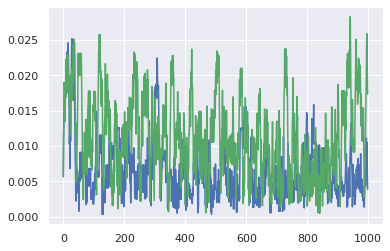

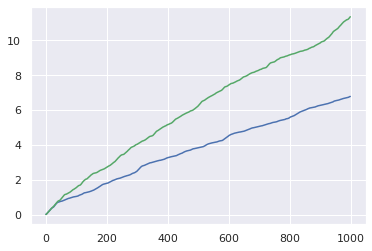

In [22]:
sns.set_style('darkgrid')
print(action1.shape, np.linalg.norm(action1,axis=1).shape)
print(env_traj1[1], env_traj1[0])
print(np.linalg.norm(env_traj1[1]-env_traj1[0]))
energy1 = [np.linalg.norm(env_traj1[i+1]-env_traj1[i]) for i in range(len(env_traj1)-1)]
plt.plot(energy1,'b')
energy2 = [np.linalg.norm(env_traj2[i+1]-env_traj2[i]) for i in range(len(env_traj2)-1)]
plt.plot(energy2,'g')
# plt.plot(np.linalg.norm(action2, axis=1))
# plt.savefig('energy_vs_time.pdf')
plt.show()
plt.plot(np.cumsum(energy1),'b')
plt.plot(np.cumsum(energy2),'g')
# plt.savefig('cumenergy_vs_time.pdf')